In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, SymLogNorm
from scipy.constants import mu_0
import ipywidgets

In [2]:
moment = 1
orientation = np.r_[0, 0, 1]
location = np.r_[0, 0, 0]

$$
\vec{b} = \frac{\mu_0}{4 \pi}\left(\frac{3\hat{r}(\vec{m}\cdot\hat{r}) - \vec{m}}{r^3}\right)
$$

In [3]:
def vector_distance(xyz, origin=np.r_[0, 0, 0]):
    """
    Vector distance between data points (xyz) and an origin point
    """
    dx = xyz[:, 0] - origin[0]
    dy = xyz[:, 1] - origin[1]
    dz = xyz[:, 2] - origin[2]

    return np.vstack([dx, dy, dz]).T

In [4]:
def dipole_magnetic_flux(
    xyz, orientation=np.r_[1, 0, 0], location=np.r_[0, 0, 0], moment=1
):
    """
    solution for a static magnetic dipole in a wholespace
    """
    # normalize orientation to unit vector 
    orientation = orientation / np.linalg.norm(orientation)
    
    # nnunmber of observed data 
    n_obs = xyz.shape[0]
    
    # distance between data and dipole
    r_vec = vector_distance(xyz, location)
    
    r_amplitude = np.sqrt((r_vec**2).sum(1)) # sqrt(sum(x^2 + y^2 + z^2))
    r_amplitude = r_amplitude[:, None].repeat(3, axis=1)  # repeat since we are working with vectors
    
    r_hat = r_vec / r_amplitude
    
    # broadcast moment so we are working with m of the right size
    m_vec = (
        moment * np.atleast_2d(orientation).repeat(n_obs, axis=0)
    )
    m_dot_r_hat = (m_vec * r_hat).sum(axis=1)

    # Repeat the scalars
    m_dot_r_hat = np.atleast_2d(m_dot_r_hat).T.repeat(3, axis=1)

    b = (mu_0 / (4 * np.pi)) * (
        (3 * r_hat * m_dot_r_hat - m_vec) / r_amplitude**3
    )

    return b

In [5]:
x = np.linspace(-36, 36, 100)
y = np.linspace(-36, 36, 100)
z = np.r_[10]

In [6]:
xyz_list = np.meshgrid(x, y, z)

In [7]:
xyz = np.vstack([dim.flatten() for dim in xyz_list]).T

In [8]:
magnetic_flux = dipole_magnetic_flux(xyz)

In [9]:
def plot_component(v, ax, component="amplitude", logscale=False):
    
    norm = Normalize()
    
    if component.lower() == "amplitude":
        plotme = np.sqrt((v**2).sum(1))
        if logscale is True:
            norm = LogNorm()
    else:
        if logscale is True:
            norm = SymLogNorm()
        if component.lower() == "x":
            plotme = v[:, 0]
        elif component.lower() == "y":
            plotme = v[:, 1]
        elif component.lower() == "z":
            plotme = v[:, 2]
        else: 
            raise Exception(f"invalid component {component}. component must be in ['amplitude', 'x', 'y', 'z']")
        
    plt.colorbar(
        ax.pcolormesh(
            x, y, plotme.reshape(len(x), len(y)), norm=norm
        ), ax=ax
    )
    ax.axis('square')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

In [10]:
def plot_streamlines(v, ax):
    vx = v[:, 0].reshape(len(x), len(y))
    vy = v[:, 1].reshape(len(x), len(y))
    ax.streamplot(x, y, vx, vy, color='k')

<ipython-input-9-746c447f5302>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(


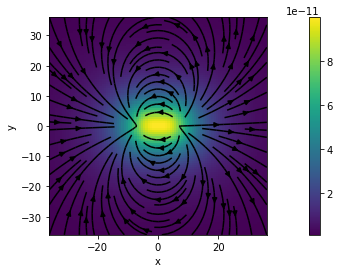

In [11]:
fig, ax = plt.subplots(1, 1)
plot_component(magnetic_flux, ax)
plot_streamlines(magnetic_flux, ax)